In [1]:
#import modules
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import math
%matplotlib inline

#loading the data
train = pd.read_csv('../dataset/train.csv')
test = pd.read_csv('../dataset/test.csv')

/tmp/ipykernel_20/1852567275.py:11: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  train = pd.read_csv('/kaggle/input/football-match-probability-prediction/train.csv')


In [2]:
train

,id,target,home_team_name,away_team_name,match_date,league_name,league_id,is_cup,home_team_coach_id,away_team_coach_id,...,away_team_history_league_id_1,away_team_history_league_id_2,away_team_history_league_id_3,away_team_history_league_id_4,away_team_history_league_id_5,away_team_history_league_id_6,away_team_history_league_id_7,away_team_history_league_id_8,away_team_history_league_id_9,away_team_history_league_id_10
0,11906497,away,Newell's Old Boys,River Plate,2019-12-01 00:45:00,Superliga,636,False,468196.0,468200.0,...,1122.0,642.0,636.0,636.0,636.0,1122.0,636.0,642.0,636.0,1122.0
1,11984383,home,Real Estelí,Deportivo Las Sabanas,2019-12-01 01:00:00,Primera Division,752,False,516788.0,22169161.0,...,752.0,752.0,752.0,752.0,752.0,752.0,752.0,752.0,752.0,752.0
2,11983301,draw,UPNFM,Marathón,2019-12-01 01:00:00,Liga Nacional,734,False,2510608.0,456313.0,...,734.0,734.0,734.0,734.0,734.0,734.0,734.0,734.0,734.0,734.0
3,11983471,away,León,Morelia,2019-12-01 01:00:00,Liga MX,743,False,1552508.0,465797.0,...,743.0,743.0,743.0,743.0,743.0,743.0,743.0,743.0,746.0,743.0
4,11883005,home,Cobán Imperial,Iztapa,2019-12-01 01:00:00,Liga Nacional,705,False,429958.0,426870.0,...,705.0,705.0,705.0,705.0,705.0,705.0,705.0,705.0,705.0,705.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
110933,18030016,draw,Zamora Fútbol Club,Hermanos Colmenares,2021-04-30 23:00:00,Primera Division,800,False,7708122.0,37564088.0,...,800.0,800.0,1101.0,1101.0,803.0,803.0,803.0,803.0,803.0,803.0
110934,18030096,away,Royal Pari,Oriente Petrolero,2021-04-30 23:00:00,Liga De Futbol Prof,1098,False,465833.0,16488543.0,...,1098.0,1098.0,1098.0,1098.0,1098.0,1098.0,1098.0,1098.0,1098.0,1098.0
110935,17715497,draw,São Bernardo,Água Santa,2021-04-30 23:00:00,Paulista A2,1314,False,8416491.0,528562.0,...,1314.0,1314.0,1314.0,1314.0,1314.0,1314.0,1314.0,1314.0,1746.0,1746.0
110936,17944153,away,Everton,La Serena,2021-05-01 00:00:00,Primera Division,663,False,6973085.0,471757.0,...,663.0,663.0,663.0,663.0,663.0,663.0,663.0,663.0,663.0,663.0


# Sub ultils function for for convenience and better speed of manipulation

In [3]:
def is_cup_conversion(df):
    '''convert is_cup column from boolean to 0/1'''
    df.is_cup = df.is_cup.apply(lambda x: np.multiply(x, 1) )
    df['is_cup'].fillna(0, inplace=True) # missing value filled with 0, ie non-cup game
    return df

In [4]:
def convert_to_long_form(df, feature_columns, history_columns):
    '''converting the history columns into long form, for convenience and better speed of manipulation'''
    stubname=[
            'home_team_history_match_date',
           'home_team_history_is_play_home',
           'home_team_history_is_cup',
           'home_team_history_goal',
           'home_team_history_opponent_goal',
           'home_team_history_rating',
           'home_team_history_opponent_rating',
           'home_team_history_coach',
           'home_team_history_league_id',
           'away_team_history_match_date',
           'away_team_history_is_play_home',
           'away_team_history_is_cup',
           'away_team_history_goal',
           'away_team_history_opponent_goal',
           'away_team_history_rating',
           'away_team_history_opponent_rating',
           'away_team_history_coach',
           'away_team_history_league_id']
    df_long=pd.wide_to_long(df[feature_columns+history_columns], stubnames=stubname, i='id', j='match', sep='_')
    df_long=df_long.reset_index().sort_values(by=['id','match'])
    return df_long

In [5]:
def has_coach_change(df):
    '''add features indicating whether home and away teams have changed coach'''
    
    df['home_has_coach_change'] = df.apply(lambda r: any([(r['home_team_coach_id']!=r[f'home_team_history_coach_{i}']) 
                                                    & (np.isnan(r[f'home_team_history_coach_{i}'])==False) for i in range(1,11) ]) , axis=1)
    df['home_has_coach_change'] = df['home_has_coach_change'].apply(lambda x: np.multiply(x, 1) )
    df['home_has_coach_change'].fillna(0, inplace=True)
    df['away_has_coach_change'] = df.apply(lambda r: any([(r['away_team_coach_id']!=r[f'away_team_history_coach_{i}']) 
                                                    & (np.isnan(r[f'away_team_history_coach_{i}'])==False) for i in range(1,11) ]) , axis=1)
    df['away_has_coach_change'] = df['away_has_coach_change'].apply(lambda x: np.multiply(x, 1) ).fillna(0, inplace=True)
    df['away_has_coach_change'].fillna(0, inplace=True)
    return df

In [6]:
feature_columns = ['id', 'match_date','league_id','is_cup','home_team_coach_id','away_team_coach_id','home_has_coach_change','away_has_coach_change']
history_columns = [col for col in train.columns if col[-1].isdigit()]

In [7]:
def add_match_interval(df):
    '''add features indicating the time gaps between the match days of previous matches for the home and away teams, 
    and how long they played 3 matches and 6 matches,as an reflection of fatique factor'''
    for i in [1,2,5]:
        home_team_history_match_interval = (df.groupby('id').match_date.first().apply(pd.Timestamp) \
             - df.query('match ==1').groupby('id').home_team_history_match_date.first().apply(pd.Timestamp) ) /np.timedelta64(1, "D")
        df=df.join(home_team_history_match_interval.to_frame(name=f'home_team_history_match_interval_{i}'), on='id')
        
        away_team_history_match_interval = (df.groupby('id').match_date.first().apply(pd.Timestamp) \
             - df.query('match ==1').groupby('id').away_team_history_match_date.first().apply(pd.Timestamp) ) /np.timedelta64(1, "D")
        df=df.join(away_team_history_match_interval.to_frame(name=f'away_team_history_match_interval_{i}'), on='id')
        
    return df

In [8]:
def result_point(goal_difference):
    if goal_difference > 0:
        return 3
    elif goal_difference==0:
        return 1
    elif goal_difference < 0:
        return 0
    else:
        return np.NaN

In [9]:
def add_form_features(df):
    '''adding form features for home and away teams, including rating difference and goal difference for each previous match,
    and the average points got, average goal scored, average goal conceded and average goal difference up to that match as previous n-match form'''
    
    df['home_team_history_goal_difference']=df['home_team_history_goal']-df['home_team_history_opponent_goal']
    df['away_team_history_goal_difference']=df['away_team_history_goal']-df['away_team_history_opponent_goal']
    df['home_team_history_point']=df.home_team_history_goal_difference.apply(result_point)
    df['away_team_history_point']=df.away_team_history_goal_difference.apply(result_point)
    df['home_team_history_rating_difference']=df['home_team_history_rating']-df['home_team_history_opponent_rating']
    df['away_team_history_rating_difference']=df['away_team_history_rating']-df['away_team_history_opponent_rating']
    
    home_team_history_goal_info_available=df.groupby('id').home_team_history_goal_difference.count()
    df=df.join(home_team_history_goal_info_available.to_frame(name='home_team_history_goal_info_available'), on='id')
    away_team_history_goal_info_available=df.groupby('id').away_team_history_goal_difference.count()
    df=df.join(away_team_history_goal_info_available.to_frame(name='away_team_history_goal_info_available'), on='id')
    home_team_history_rating_info_available=df.groupby('id').home_team_history_rating_difference.count()
    df=df.join(home_team_history_rating_info_available.to_frame(name='home_team_history_rating_info_available'), on='id')
    away_team_history_rating_info_available=df.groupby('id').away_team_history_rating_difference.count()
    df=df.join(away_team_history_rating_info_available.to_frame(name='away_team_history_rating_info_available'), on='id')
    
        
    for i in [5,10]: # are made for past 10 matches and past 5 matches as recent form and most recent form features.
        home_team_history_average_goal_scored=df.query(f'match <= {i}').groupby('id').home_team_history_goal.mean()
        df=df.join(home_team_history_average_goal_scored.to_frame(name=f'home_team_history_average_goal_scored_{i}'), on='id')
        home_team_history_average_goal_conceded=df.query(f'match <= {i}').groupby('id').home_team_history_opponent_goal.mean()
        df=df.join(home_team_history_average_goal_conceded.to_frame(name=f'home_team_history_average_goal_conceded_{i}'), on='id')
        
        away_team_history_average_goal_scored=df.query(f'match <= {i}').groupby('id').away_team_history_goal.mean()
        df=df.join(away_team_history_average_goal_scored.to_frame(name=f'away_team_history_average_goal_scored_{i}'), on='id')
        away_team_history_average_goal_conceded=df.query(f'match <= {i}').groupby('id').away_team_history_opponent_goal.mean()
        df=df.join(away_team_history_average_goal_conceded.to_frame(name=f'away_team_history_average_goal_conceded_{i}'), on='id')
        
        df[f'home_team_history_average_goal_difference_{i}']=df[f'home_team_history_average_goal_scored_{i}']-df[f'home_team_history_average_goal_conceded_{i}']
        df[f'away_team_history_average_goal_difference_{i}']=df[f'away_team_history_average_goal_scored_{i}']-df[f'away_team_history_average_goal_conceded_{i}']
        
        home_team_history_average_point=df.query(f'match <= {i}').groupby('id').home_team_history_point.mean()
        df=df.join(home_team_history_average_point.to_frame(name=f'home_team_history_average_point_{i}'), on='id')
        away_team_history_average_point=df.query(f'match <= {i}').groupby('id').away_team_history_point.mean()
        df=df.join(away_team_history_average_point.to_frame(name=f'away_team_history_average_point_{i}'), on='id')
        home_team_history_average_point_std=df.query(f'match <= {i}').groupby('id').home_team_history_point.std()
        df=df.join(home_team_history_average_point_std.to_frame(name=f'home_team_history_average_point_std_{i}'), on='id')
        away_team_history_average_point_std=df.query(f'match <= {i}').groupby('id').away_team_history_point.std()
        df=df.join(away_team_history_average_point_std.to_frame(name=f'away_team_history_average_point_std_{i}'), on='id')
        
        home_team_history_median_rating_difference=df.query(f'match <= {i}').groupby('id').home_team_history_rating_difference.median()
        df=df.join(home_team_history_median_rating_difference.to_frame(name=f'home_team_history_median_rating_difference_{i}'), on='id')
        away_team_history_median_rating_difference=df.query(f'match <= {i}').groupby('id').away_team_history_rating_difference.median()
        df=df.join(away_team_history_median_rating_difference.to_frame(name=f'away_team_history_median_rating_difference_{i}'), on='id')
        home_team_history_rating_difference_std=df.query(f'match <= {i}').groupby('id').home_team_history_rating_difference.std()
        df=df.join(home_team_history_rating_difference_std.to_frame(name=f'home_team_history_rating_difference_std_{i}'), on='id')
        away_team_history_rating_difference_std=df.query(f'match <= {i}').groupby('id').away_team_history_rating_difference.std()
        df=df.join(away_team_history_rating_difference_std.to_frame(name=f'away_team_history_rating_difference_std_{i}'), on='id')
    
    home_team_home_form_average_goal_scored=df.query('home_team_history_is_play_home==1').groupby('id').home_team_history_goal.mean()
    df=df.join(home_team_home_form_average_goal_scored.to_frame(name='home_team_home_form_average_goal_scored'), on='id')
    home_team_home_form_average_goal_conceded=df.query('home_team_history_is_play_home==1').groupby('id').home_team_history_opponent_goal.mean()
    df=df.join(home_team_home_form_average_goal_conceded.to_frame(name='home_team_home_form_average_goal_conceded'), on='id')
    home_team_home_form_average_goal_difference=df.query('home_team_history_is_play_home==1').groupby('id').home_team_history_goal_difference.mean()
    df=df.join(home_team_home_form_average_goal_difference.to_frame(name='home_team_home_form_average_goal_difference'), on='id')
    home_team_home_form_goal_difference_std=df.query('home_team_history_is_play_home==1').groupby('id').home_team_history_goal_difference.std()
    df=df.join(home_team_home_form_goal_difference_std.to_frame(name='home_team_home_form_goal_difference_std'), on='id')
    home_team_home_form_win_rate=df.query('(home_team_history_is_play_home==1) & (home_team_history_point==3)').groupby('id').home_team_history_point.count()/df.query('home_team_history_is_play_home==1').groupby('id').home_team_history_is_play_home.count()
    df=df.join(home_team_home_form_win_rate.to_frame(name='home_team_home_form_win_rate'), on='id')
    home_team_home_form_draw_rate=df.query('(home_team_history_is_play_home==1) & (home_team_history_point==1)').groupby('id').home_team_history_point.count()/df.query('home_team_history_is_play_home==1').groupby('id').home_team_history_is_play_home.count()
    df=df.join(home_team_home_form_draw_rate.to_frame(name='home_team_home_form_draw_rate'), on='id')
    home_team_home_form_lose_rate=df.query('(home_team_history_is_play_home==1) & (home_team_history_point==0)').groupby('id').home_team_history_point.count()/df.query('home_team_history_is_play_home==1').groupby('id').home_team_history_is_play_home.count()
    df=df.join(home_team_home_form_lose_rate.to_frame(name='home_team_home_form_lose_rate'), on='id')
    home_team_home_form_average_point=df.query('home_team_history_is_play_home==1').groupby('id').home_team_history_point.mean()
    df=df.join(home_team_home_form_average_point.to_frame(name='home_team_home_form_average_point'), on='id')
    home_team_home_form_median_rating_difference=df.query('home_team_history_is_play_home==1').groupby('id').home_team_history_rating_difference.median()
    df=df.join(home_team_home_form_median_rating_difference.to_frame(name='home_team_home_form_median_rating_difference'), on='id')
    home_team_home_form_goal_info_available=df.query('home_team_history_is_play_home==1').groupby('id').home_team_history_goal_difference.count()
    df=df.join(home_team_home_form_goal_info_available.to_frame(name='home_team_home_form_goal_info_available'), on='id')
    home_team_home_form_rating_info_available=df.query('home_team_history_is_play_home==1').groupby('id').home_team_history_rating_difference.count()
    df=df.join(home_team_home_form_rating_info_available.to_frame(name='home_team_home_form_rating_info_available'), on='id')
    
    away_team_away_form_average_goal_scored=df.query('away_team_history_is_play_home==0').groupby('id').away_team_history_goal.mean()
    df=df.join(away_team_away_form_average_goal_scored.to_frame(name='away_team_away_form_average_goal_scored'), on='id')
    away_team_away_form_average_goal_conceded=df.query('away_team_history_is_play_home==0').groupby('id').away_team_history_opponent_goal.mean()
    df=df.join(away_team_away_form_average_goal_conceded.to_frame(name='away_team_away_form_average_goal_conceded'), on='id')
    away_team_away_form_average_goal_difference=df.query('away_team_history_is_play_home==0').groupby('id').away_team_history_goal_difference.mean()
    df=df.join(away_team_away_form_average_goal_difference.to_frame(name='away_team_away_form_average_goal_difference'), on='id')
    away_team_away_form_goal_difference_std=df.query('away_team_history_is_play_home==0').groupby('id').away_team_history_goal_difference.std()
    df=df.join(away_team_away_form_goal_difference_std.to_frame(name='away_team_away_form_goal_difference_std'), on='id')
    away_team_away_form_win_rate=df.query('(away_team_history_is_play_home==0) & (away_team_history_point==3)').groupby('id').away_team_history_point.count()/df.query('away_team_history_is_play_home==0').groupby('id').away_team_history_is_play_home.count()
    df=df.join(away_team_away_form_win_rate.to_frame(name='away_team_away_form_win_rate'), on='id')
    away_team_away_form_draw_rate=df.query('(away_team_history_is_play_home==0) & (away_team_history_point==1)').groupby('id').away_team_history_point.count()/df.query('away_team_history_is_play_home==0').groupby('id').away_team_history_is_play_home.count()
    df=df.join(away_team_away_form_draw_rate.to_frame(name='away_team_away_form_draw_rate'), on='id')
    away_team_away_form_lose_rate=df.query('(away_team_history_is_play_home==0) & (away_team_history_point==0)').groupby('id').away_team_history_point.count()/df.query('away_team_history_is_play_home==0').groupby('id').away_team_history_is_play_home.count()
    df=df.join(away_team_away_form_lose_rate.to_frame(name='away_team_away_form_lose_rate'), on='id')
    away_team_away_form_average_point=df.query('away_team_history_is_play_home==0').groupby('id').away_team_history_point.mean()
    df=df.join(away_team_away_form_average_point.to_frame(name='away_team_away_form_average_point'), on='id')
    away_team_away_form_median_rating_difference=df.query('away_team_history_is_play_home==0').groupby('id').away_team_history_rating_difference.median()
    df=df.join(away_team_away_form_median_rating_difference.to_frame(name='away_team_away_form_median_rating_difference'), on='id')
    away_team_away_form_goal_info_available=df.query('away_team_history_is_play_home==0').groupby('id').away_team_history_goal_difference.count()
    df=df.join(away_team_away_form_goal_info_available.to_frame(name='away_team_away_form_goal_info_available'), on='id')
    away_team_away_form_rating_info_available=df.query('away_team_history_is_play_home==0').groupby('id').away_team_history_rating_difference.count()
    df=df.join(away_team_away_form_rating_info_available.to_frame(name='away_team_away_form_rating_info_available'), on='id')
    
    return df

In [10]:
def add_attack_defense_strength_features(df):
    '''getting goal rates of the league/competition, and calculate the attack and defense strength of a team relative to the league/competition,
    and the expected goals based on this'''
    
    home_history_columns=['home_team_history_match_date',
           'home_team_history_is_play_home',
           'home_team_history_is_cup',
           'home_team_history_goal',
           'home_team_history_opponent_goal',
           'home_team_history_rating',
           'home_team_history_opponent_rating',
           'home_team_history_coach',
           'home_team_history_league_id']
    home_history=df[home_history_columns]
    home_history=home_history.drop_duplicates()
    
    away_history_columns=['away_team_history_match_date',
           'away_team_history_is_play_home',
           'away_team_history_is_cup',
           'away_team_history_goal',
           'away_team_history_opponent_goal',
           'away_team_history_rating',
           'away_team_history_opponent_rating',
           'away_team_history_coach',
           'away_team_history_league_id']
    away_history=df[away_history_columns]
    away_history=away_history.drop_duplicates()
    
    league_total_goal = home_history.groupby('home_team_history_league_id').home_team_history_goal.sum() \
                    + home_history.groupby('home_team_history_league_id').home_team_history_opponent_goal.sum() \
                    + away_history.groupby('away_team_history_league_id').away_team_history_goal.sum() \
                    + away_history.groupby('away_team_history_league_id').away_team_history_opponent_goal.sum()
    league_total_game = home_history.groupby('home_team_history_league_id').home_team_history_goal.count() \
                    + home_history.groupby('home_team_history_league_id').home_team_history_opponent_goal.count() \
                    + away_history.groupby('away_team_history_league_id').away_team_history_goal.count() \
                    + away_history.groupby('away_team_history_league_id').away_team_history_opponent_goal.count() 
    league_average_goal = league_total_goal/league_total_game
    df=df.join(league_average_goal.to_frame(name='league_average_goal'), on='league_id')
    df.league_average_goal=df.league_average_goal.fillna(df.league_average_goal.mean())
    
    league_total_home_goal = home_history.query('home_team_history_is_play_home==1').groupby('home_team_history_league_id').home_team_history_goal.sum() \
                    + home_history.query('home_team_history_is_play_home==0').groupby('home_team_history_league_id').home_team_history_opponent_goal.sum() \
                    + away_history.query('away_team_history_is_play_home==1').groupby('away_team_history_league_id').away_team_history_goal.sum() \
                    + away_history.query('away_team_history_is_play_home==0').groupby('away_team_history_league_id').away_team_history_opponent_goal.sum()
    league_total_home_goal_game = home_history.query('home_team_history_is_play_home==1').groupby('home_team_history_league_id').home_team_history_goal.count() \
                    + home_history.query('home_team_history_is_play_home==0').groupby('home_team_history_league_id').home_team_history_opponent_goal.count() \
                    + away_history.query('away_team_history_is_play_home==1').groupby('away_team_history_league_id').away_team_history_goal.count() \
                    + away_history.query('away_team_history_is_play_home==0').groupby('away_team_history_league_id').away_team_history_opponent_goal.count()
    league_average_home_goal = league_total_home_goal/league_total_home_goal_game
    df=df.join(league_average_home_goal.to_frame(name='league_average_home_goal'), on='league_id')
    df.league_average_home_goal=df.league_average_home_goal.fillna(df.league_average_home_goal.mean())
    
    league_total_away_goal = home_history.query('home_team_history_is_play_home==0').groupby('home_team_history_league_id').home_team_history_goal.sum() \
                    + home_history.query('home_team_history_is_play_home==1').groupby('home_team_history_league_id').home_team_history_opponent_goal.sum() \
                    + away_history.query('away_team_history_is_play_home==0').groupby('away_team_history_league_id').away_team_history_goal.sum() \
                    + away_history.query('away_team_history_is_play_home==1').groupby('away_team_history_league_id').away_team_history_opponent_goal.sum()
    league_total_away_goal_game = home_history.query('home_team_history_is_play_home==0').groupby('home_team_history_league_id').home_team_history_goal.count() \
                    + home_history.query('home_team_history_is_play_home==1').groupby('home_team_history_league_id').home_team_history_opponent_goal.count() \
                    + away_history.query('away_team_history_is_play_home==0').groupby('away_team_history_league_id').away_team_history_goal.count() \
                    + away_history.query('away_team_history_is_play_home==1').groupby('away_team_history_league_id').away_team_history_opponent_goal.count()
    league_average_away_goal = league_total_away_goal/league_total_away_goal_game
    df=df.join(league_average_away_goal.to_frame(name='league_average_away_goal'), on='league_id')
    df.league_average_away_goal=df.league_average_away_goal.fillna(df.league_average_away_goal.mean())
    
    df['home_team_attack_strength'] = df.home_team_history_average_goal_scored_10/df.league_average_goal
    df['home_team_defense_strength'] = df.home_team_history_average_goal_conceded_10/df.league_average_goal
    df['away_team_attack_strength'] = df.away_team_history_average_goal_scored_10/df.league_average_goal
    df['away_team_defense_strength'] = df.away_team_history_average_goal_conceded_10/df.league_average_goal
    df['home_team_expected_goal'] = df.league_average_home_goal*df.home_team_attack_strength*df.away_team_defense_strength
    df['away_team_expected_goal'] = df.league_average_away_goal*df.away_team_attack_strength*df.home_team_defense_strength
    
    
    #getting teams' record of goal scored and conceded in each league
    home_team_league_average_goal_scored=df.groupby(['id','home_team_history_league_id']).home_team_history_goal.agg(['mean']).reset_index()
    home_team_league_average_goal_scored.columns=['id','league_id','home_team_league_average_goal_scored']
    df=pd.merge(df, home_team_league_average_goal_scored, how='left')
    
    home_team_league_average_goal_conceded=df.groupby(['id','home_team_history_league_id']).home_team_history_opponent_goal.agg(['mean']).reset_index()
    home_team_league_average_goal_conceded.columns=['id','league_id','home_team_league_average_goal_conceded']
    df=pd.merge(df, home_team_league_average_goal_conceded, how='left')
    
    away_team_league_average_goal_scored=df.groupby(['id','away_team_history_league_id']).away_team_history_goal.agg(['mean']).reset_index()
    away_team_league_average_goal_scored.columns=['id','league_id','away_team_league_average_goal_scored']
    df=pd.merge(df, away_team_league_average_goal_scored, how='left')
    
    away_team_league_average_goal_conceded=df.groupby(['id','away_team_history_league_id']).away_team_history_opponent_goal.agg(['mean']).reset_index()
    away_team_league_average_goal_conceded.columns=['id','league_id','away_team_league_average_goal_conceded']
    df=pd.merge(df, away_team_league_average_goal_conceded, how='left')
    
    #setting another set of attack, defense and expected goal data based on team's record
    df['home_team_league_attack_strength'] = df.home_team_league_average_goal_scored/df.league_average_goal
    df['home_team_league_defense_strength'] = df.home_team_league_average_goal_conceded/df.league_average_goal
    df['away_team_league_attack_strength'] = df.away_team_league_average_goal_scored/df.league_average_goal
    df['away_team_league_defense_strength'] = df.away_team_league_average_goal_conceded/df.league_average_goal
    df['home_team_league_expected_goal'] = df.league_average_home_goal*df.home_team_league_attack_strength*df.away_team_league_defense_strength
    df['away_team_league_expected_goal'] = df.league_average_away_goal*df.away_team_league_attack_strength*df.home_team_league_defense_strength
    
    #getting coach's record of goal scored and conceded in each league
    home_coach_goal=df.drop_duplicates(subset=home_history_columns)[['home_team_history_coach','home_team_history_league_id', \
                                                             'home_team_history_match_date','home_team_history_goal']].dropna()
    home_coach_goal=home_coach_goal.sort_values(by=['home_team_history_coach','home_team_history_league_id','home_team_history_match_date'],\
                                                ascending=[True,True,True])
    home_coach_goal2=home_coach_goal.set_index(['home_team_history_coach','home_team_history_league_id','home_team_history_match_date']\
                                             ).groupby(level=1, as_index=False).home_team_history_goal.agg(['cumsum','cumcount']).reset_index()
    home_coach_goal2['home_team_coach_league_average_goal_scored']=(home_coach_goal2['cumsum'])/(home_coach_goal2['cumcount']+1)
    home_coach_goal3=home_coach_goal2[['home_team_history_coach','home_team_history_league_id',\
                                       'home_team_history_match_date','home_team_coach_league_average_goal_scored']]
    home_coach_goal3.columns=['home_team_coach_id','league_id','home_team_history_match_date','home_team_coach_league_average_goal_scored']
    home_coach_goal3=home_coach_goal3.drop_duplicates(subset=['home_team_coach_id','league_id','home_team_history_match_date'])
    df=df.merge(home_coach_goal3, how='left')
    
    home_coach_conceded=df.drop_duplicates(subset=home_history_columns)[['home_team_history_coach','home_team_history_league_id', \
                                                             'home_team_history_match_date','home_team_history_opponent_goal']].dropna()
    home_coach_conceded=home_coach_conceded.sort_values(by=['home_team_history_coach','home_team_history_league_id','home_team_history_match_date'],\
                                                ascending=[True,True,True])
    home_coach_conceded2=home_coach_conceded.set_index(['home_team_history_coach','home_team_history_league_id','home_team_history_match_date']\
                                             ).groupby(level=1, as_index=False).home_team_history_opponent_goal.agg(['cumsum','cumcount']).reset_index()
    home_coach_conceded2['home_team_coach_league_average_goal_conceded']=(home_coach_conceded2['cumsum'])/(home_coach_conceded2['cumcount']+1)
    home_coach_conceded3=home_coach_conceded2[['home_team_history_coach','home_team_history_league_id',\
                                       'home_team_history_match_date','home_team_coach_league_average_goal_conceded']]
    home_coach_conceded3.columns=['home_team_coach_id','league_id','home_team_history_match_date','home_team_coach_league_average_goal_conceded']
    home_coach_conceded3=home_coach_conceded3.drop_duplicates(subset=['home_team_coach_id','league_id','home_team_history_match_date'])
    df=df.merge(home_coach_conceded3, how='left')
    
    away_coach_goal=df.drop_duplicates(subset=away_history_columns)[['away_team_history_coach','away_team_history_league_id', \
                                                             'away_team_history_match_date','away_team_history_goal']].dropna()
    away_coach_goal=away_coach_goal.sort_values(by=['away_team_history_coach','away_team_history_league_id','away_team_history_match_date'],\
                                                ascending=[True,True,True])
    away_coach_goal2=away_coach_goal.set_index(['away_team_history_coach','away_team_history_league_id','away_team_history_match_date']\
                                             ).groupby(level=1, as_index=False).away_team_history_goal.agg(['cumsum','cumcount']).reset_index()
    away_coach_goal2['away_team_coach_league_average_goal_scored']=(away_coach_goal2['cumsum'])/(away_coach_goal2['cumcount']+1)
    away_coach_goal3=away_coach_goal2[['away_team_history_coach','away_team_history_league_id',\
                                       'away_team_history_match_date','away_team_coach_league_average_goal_scored']]
    away_coach_goal3.columns=['away_team_coach_id','league_id','away_team_history_match_date','away_team_coach_league_average_goal_scored']
    away_coach_goal3=away_coach_goal3.drop_duplicates(subset=['away_team_coach_id','league_id','away_team_history_match_date'])
    df=df.merge(away_coach_goal3, how='left')
    
    away_coach_conceded=df.drop_duplicates(subset=away_history_columns)[['away_team_history_coach','away_team_history_league_id', \
                                                             'away_team_history_match_date','away_team_history_opponent_goal']].dropna()
    away_coach_conceded=away_coach_conceded.sort_values(by=['away_team_history_coach','away_team_history_league_id','away_team_history_match_date'],\
                                                ascending=[True,True,True])
    away_coach_conceded2=away_coach_conceded.set_index(['away_team_history_coach','away_team_history_league_id','away_team_history_match_date']\
                                             ).groupby(level=1, as_index=False).away_team_history_opponent_goal.agg(['cumsum','cumcount']).reset_index()
    away_coach_conceded2['away_team_coach_league_average_goal_conceded']=(away_coach_conceded2['cumsum'])/(away_coach_conceded2['cumcount']+1)
    away_coach_conceded3=away_coach_conceded2[['away_team_history_coach','away_team_history_league_id',\
                                       'away_team_history_match_date','away_team_coach_league_average_goal_conceded']]
    away_coach_conceded3.columns=['away_team_coach_id','league_id','away_team_history_match_date','away_team_coach_league_average_goal_conceded']
    away_coach_conceded3=away_coach_conceded3.drop_duplicates(subset=['away_team_coach_id','league_id','away_team_history_match_date'])
    df=df.merge(away_coach_conceded3, how='left')
    
    #setting another set of attack, defense and expected goal data based on coach's record
    df['home_team_coach_attack_strength'] = df.home_team_coach_league_average_goal_scored/df.league_average_goal
    df['home_team_coach_defense_strength'] = df.home_team_coach_league_average_goal_conceded/df.league_average_goal
    df['away_team_coach_attack_strength'] = df.away_team_coach_league_average_goal_scored/df.league_average_goal
    df['away_team_coach_defense_strength'] = df.away_team_coach_league_average_goal_conceded/df.league_average_goal
    df['home_team_coach_expected_goal'] = df.league_average_home_goal*df.home_team_coach_attack_strength*df.away_team_coach_defense_strength
    df['away_team_coach_expected_goal'] = df.league_average_away_goal*df.away_team_coach_attack_strength*df.home_team_coach_defense_strength
    
    return df

In [11]:
def reshape(df):
    '''reshape the dataframe back to wide form'''
    history_columns=['home_team_history_is_play_home',
              'home_team_history_is_cup',
              'home_team_history_goal',
              'home_team_history_opponent_goal',
              'home_team_history_rating',
              'home_team_history_opponent_rating',
              'home_team_history_coach',
              'home_team_history_league_id',
              'home_team_history_goal_difference',
              'home_team_history_point',
              'home_team_history_rating_difference',
              'away_team_history_is_play_home',
              'away_team_history_is_cup',
              'away_team_history_goal',
              'away_team_history_opponent_goal',
              'away_team_history_rating',
              'away_team_history_opponent_rating',
              'away_team_history_coach',
              'away_team_history_league_id',
              'away_team_history_goal_difference',
              'away_team_history_point',
              'away_team_history_rating_difference']
    drop_columns=['match','match_date','home_team_history_match_date','away_team_history_match_date']
    df_history=df[history_columns+['id','match']].set_index(['id','match']).unstack(level=1)
    df_history.columns = df_history.columns.map('{0[0]}_{0[1]}'.format) 
    df_history=df_history.reset_index()
    df_new=df.groupby('id').first().reset_index().drop(history_columns+drop_columns, axis=1)
    df_new=df_new.merge(df_history, how='left')
    
    return df_new
    

# Aggregate Processing

In [12]:
def preprocession(df):
    df=is_cup_conversion(df)
    df=has_coach_change(df)
    df=convert_to_long_form(df, feature_columns, history_columns)
    df=add_match_interval(df)
    df=add_form_features(df)
    df=add_attack_defense_strength_features(df)
    df.replace([np.inf, -np.inf], np.nan, inplace=True)
    df=reshape(df)
    return df

In [13]:
train_p=preprocession(train)

In [14]:
for i in train_p.columns:
    print(i, train_p.loc[467,i])

id 11864226
is_cup 0.0
league_id 453
away_team_coach_id 458731.0
away_has_coach_change 0
home_team_coach_id 456984.0
home_has_coach_change 0
home_team_history_match_interval_1 80.9375
away_team_history_match_interval_1 85.0625
home_team_history_match_interval_2 80.9375
away_team_history_match_interval_2 85.0625
home_team_history_match_interval_5 80.9375
away_team_history_match_interval_5 85.0625
home_team_history_goal_info_available 10
away_team_history_goal_info_available 10
home_team_history_rating_info_available 10
away_team_history_rating_info_available 10
home_team_history_average_goal_scored_5 1.6
home_team_history_average_goal_conceded_5 2.0
away_team_history_average_goal_scored_5 1.0
away_team_history_average_goal_conceded_5 1.6
home_team_history_average_goal_difference_5 -0.3999999999999999
away_team_history_average_goal_difference_5 -0.6000000000000001
home_team_history_average_point_5 1.4
away_team_history_average_point_5 0.8
home_team_history_average_point_std_5 1.516575088

In [15]:
train_p

,id,is_cup,league_id,away_team_coach_id,away_has_coach_change,home_team_coach_id,home_has_coach_change,home_team_history_match_interval_1,away_team_history_match_interval_1,home_team_history_match_interval_2,...,away_team_history_rating_difference_1,away_team_history_rating_difference_2,away_team_history_rating_difference_3,away_team_history_rating_difference_4,away_team_history_rating_difference_5,away_team_history_rating_difference_6,away_team_history_rating_difference_7,away_team_history_rating_difference_8,away_team_history_rating_difference_9,away_team_history_rating_difference_10
0,11428294,0.0,755,257433.0,0,468693.0,1,6.083333,5.083333,6.083333,...,-1.686090,0.193650,-5.645310,-0.767900,0.787590,-2.149730,1.712825,-7.698850,-2.681838,-2.846002
1,11428295,0.0,755,16476269.0,0,37331516.0,1,4.000000,4.083333,4.000000,...,4.695250,-1.492900,5.645310,1.304563,3.691220,-2.146200,3.962490,4.884169,0.305462,4.521120
2,11428297,0.0,755,474745.0,0,212710.0,1,3.916667,6.000000,3.916667,...,1.019475,0.969129,-3.317942,-3.691220,1.390980,2.149730,-4.685388,1.515560,0.227650,1.122891
3,11428298,0.0,755,472575.0,0,186127.0,0,4.083333,3.000000,4.083333,...,11.564250,2.321762,4.519680,5.514640,2.146200,4.990860,4.685388,7.698850,5.395681,2.607943
4,11428299,0.0,755,216631.0,0,470514.0,0,3.000000,4.000000,3.000000,...,1.934107,3.248880,-0.295988,-1.304563,-4.625480,1.604310,-3.962490,3.188925,1.174063,-1.515560
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
110933,18045358,0.0,827,NaN,0,NaN,1,4.083333,11.104167,4.083333,...,0.357700,0.249244,6.209950,2.273900,4.201512,1.521722,1.161838,-0.612333,0.432071,4.388394
110934,18046139,0.0,974,1552546.0,0,37568493.0,1,56.906250,61.000000,56.906250,...,2.292718,7.045164,4.754419,10.289600,6.621128,11.154472,4.440791,4.689725,6.181608,12.062173
110935,18046140,0.0,974,17905337.0,0,22859379.0,0,57.135417,57.031250,57.135417,...,5.968467,-2.292718,2.810922,3.259706,8.210174,0.692959,7.853025,1.485133,3.522164,6.682559
110936,18046141,0.0,974,2206663.0,0,29328646.0,1,56.208333,57.218750,56.208333,...,2.012634,3.365606,-7.045164,-2.810922,-0.385293,6.381565,-1.650481,2.810025,-1.685743,0.372788


# Tranining

In [16]:
X=train_p.drop('id', axis=1)
y=train.sort_values(by='id')['target']

In [17]:
X

,is_cup,league_id,away_team_coach_id,away_has_coach_change,home_team_coach_id,home_has_coach_change,home_team_history_match_interval_1,away_team_history_match_interval_1,home_team_history_match_interval_2,away_team_history_match_interval_2,...,away_team_history_rating_difference_1,away_team_history_rating_difference_2,away_team_history_rating_difference_3,away_team_history_rating_difference_4,away_team_history_rating_difference_5,away_team_history_rating_difference_6,away_team_history_rating_difference_7,away_team_history_rating_difference_8,away_team_history_rating_difference_9,away_team_history_rating_difference_10
0,0.0,755,257433.0,0,468693.0,1,6.083333,5.083333,6.083333,5.083333,...,-1.686090,0.193650,-5.645310,-0.767900,0.787590,-2.149730,1.712825,-7.698850,-2.681838,-2.846002
1,0.0,755,16476269.0,0,37331516.0,1,4.000000,4.083333,4.000000,4.083333,...,4.695250,-1.492900,5.645310,1.304563,3.691220,-2.146200,3.962490,4.884169,0.305462,4.521120
2,0.0,755,474745.0,0,212710.0,1,3.916667,6.000000,3.916667,6.000000,...,1.019475,0.969129,-3.317942,-3.691220,1.390980,2.149730,-4.685388,1.515560,0.227650,1.122891
3,0.0,755,472575.0,0,186127.0,0,4.083333,3.000000,4.083333,3.000000,...,11.564250,2.321762,4.519680,5.514640,2.146200,4.990860,4.685388,7.698850,5.395681,2.607943
4,0.0,755,216631.0,0,470514.0,0,3.000000,4.000000,3.000000,4.000000,...,1.934107,3.248880,-0.295988,-1.304563,-4.625480,1.604310,-3.962490,3.188925,1.174063,-1.515560
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
110933,0.0,827,NaN,0,NaN,1,4.083333,11.104167,4.083333,11.104167,...,0.357700,0.249244,6.209950,2.273900,4.201512,1.521722,1.161838,-0.612333,0.432071,4.388394
110934,0.0,974,1552546.0,0,37568493.0,1,56.906250,61.000000,56.906250,61.000000,...,2.292718,7.045164,4.754419,10.289600,6.621128,11.154472,4.440791,4.689725,6.181608,12.062173
110935,0.0,974,17905337.0,0,22859379.0,0,57.135417,57.031250,57.135417,57.031250,...,5.968467,-2.292718,2.810922,3.259706,8.210174,0.692959,7.853025,1.485133,3.522164,6.682559
110936,0.0,974,2206663.0,0,29328646.0,1,56.208333,57.218750,56.208333,57.218750,...,2.012634,3.365606,-7.045164,-2.810922,-0.385293,6.381565,-1.650481,2.810025,-1.685743,0.372788


In [18]:
y

913       away
685       away
792       draw
686       away
664       away
          ... 
110565    draw
110662    away
110721    draw
110780    away
110733    away
Name: target, Length: 110938, dtype: object

In [19]:
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
label_encoder = label_encoder.fit(y)
label_encoded_y = label_encoder.transform(y)

In [20]:
label_encoded_y

array([0, 0, 1, ..., 1, 0, 0])

In [21]:
from sklearn import model_selection
X_train, X_valid, y_train, y_valid = model_selection.train_test_split(X, label_encoded_y, train_size=0.8, random_state=42)

In [22]:
y_train

array([2, 2, 2, ..., 1, 2, 2])

In [23]:
# import xgboost as xgb
# from sklearn.model_selection import GridSearchCV

# # Define the parameter grid
# param_grid = {
#     'max_depth': [3, 5, 7],
#     'learning_rate': [0.01, 0.1, 0.5],
#     'subsample': [0.6, 0.8, 1.0],
#     'colsample_bytree': [0.6, 0.8, 1.0]
# }

# # Create an XGBoost classifier
# xgb_model = xgb.XGBClassifier(objective='multi:softprob', num_class=3, eval_metric='mlogloss', use_label_encoder=False)

# # Perform grid search
# grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, cv=3)
# grid_search.fit(X_train, y_train)

# # Print the best parameters and best score
# print("Best Parameters: ", grid_search.best_params_)
# print("Best Score: ", grid_search.best_score_)

In [24]:
import xgboost as xgb
d_train = xgb.DMatrix(X_train, y_train)
d_test = xgb.DMatrix(X_valid, y_valid)

In [25]:
best_params = {
    'booster': 'gbtree',
    'max_depth': 5, 
    'learning_rate': 0.025,
    'min_split_loss': 0.01,
    'min_child_weight': 5,
    'subsample': 0.8,
    'colsample_bytree': 0.25,
    'alpha': 2,
    'lambda': 3,
    'objective': 'multi:softprob',
    'num_class': 3,
    'eval_metric':'mlogloss'
    }

num_round = 1000
evallist = [(d_train, 'train'), (d_test, 'eval')]
pretrained = True

In [26]:
d_train

In [27]:
import pickle

if (pretrained):
    # Load the pretrained model from the .pkl file
    with open('/kaggle/input/xgboost-football/XGBoost.pkl', 'rb') as file:
        bst = pickle.load(file)
else:
    bst = xgb.train(best_params, d_train, num_round, evallist, early_stopping_rounds=20)
    # Save the model to a .pkl file
    with open('XGBoost.pkl', 'wb') as file:
        pickle.dump(bst, file)

[20:21:51] WARNING: ../src/learner.cc:1203: 
  If you are loading a serialized model (like pickle in Python, RDS in R) generated by
  older XGBoost, please export the model by calling `Booster.save_model` from that version
  first, then load it back in current version. See:

    https://xgboost.readthedocs.io/en/latest/tutorials/saving_model.html

  for more details about differences between saving model and serializing.

[20:21:51] WARNING: ../src/learner.cc:888: Found JSON model saved before XGBoost 1.6, please save the model using current version again. The support for old JSON model will be discontinued in XGBoost 2.3.
[20:21:51] WARNING: ../src/learner.cc:553: 
  If you are loading a serialized model (like pickle in Python, RDS in R) generated by
  older XGBoost, please export the model by calling `Booster.save_model` from that version
  first, then load it back in current version. See:

    https://xgboost.readthedocs.io/en/latest/tutorials/saving_model.html

  for more details a

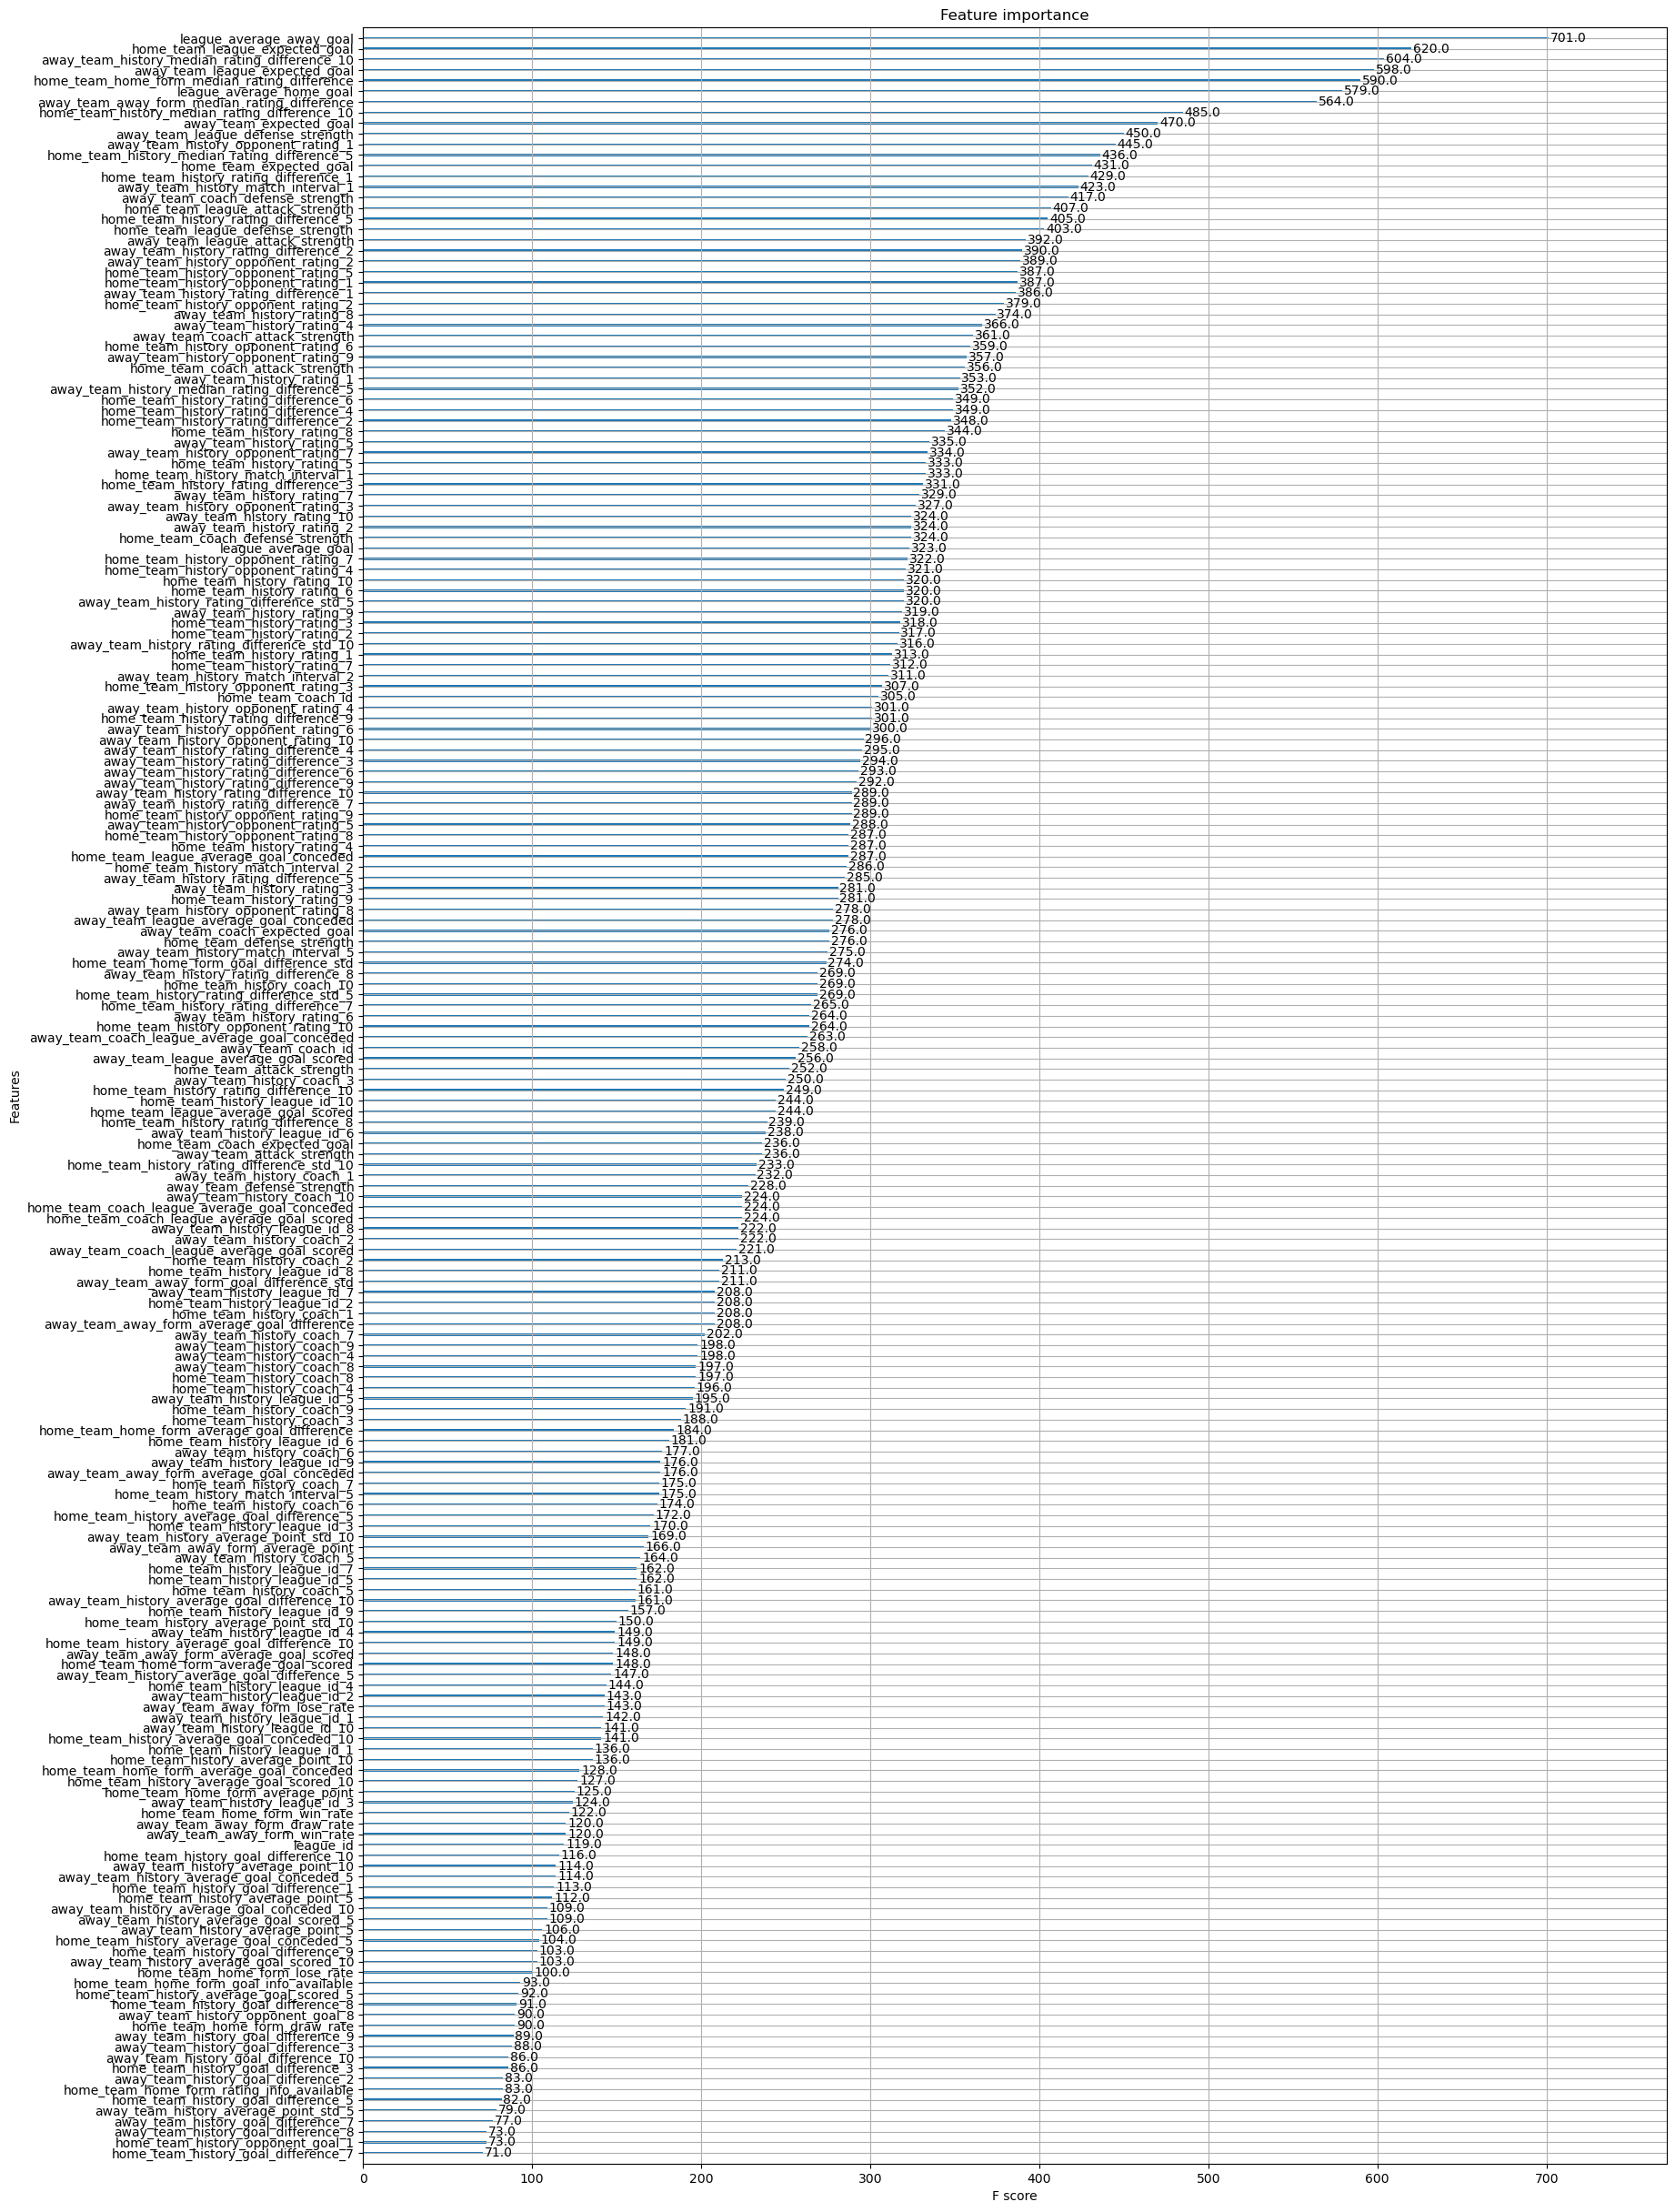

In [28]:
xgb.plot_importance(bst, max_num_features=200)
fig = plt.gcf()
fig.set_size_inches(18.5, 30.5)

# Results

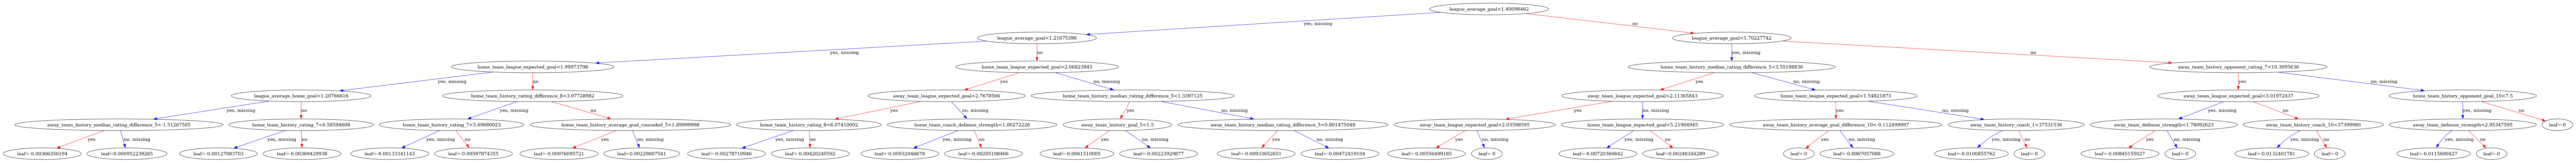

In [29]:
xgb.plot_tree(bst, num_trees=1)
fig = plt.gcf()
fig.set_size_inches(160, 100)

In [30]:
bst.best_iteration

594

In [31]:
bst.best_score

1.004851

In [32]:
test_p=preprocession(test)

In [33]:
test_p

,id,is_cup,league_id,away_team_coach_id,away_has_coach_change,home_team_coach_id,home_has_coach_change,home_team_history_match_interval_1,away_team_history_match_interval_1,home_team_history_match_interval_2,...,away_team_history_rating_difference_1,away_team_history_rating_difference_2,away_team_history_rating_difference_3,away_team_history_rating_difference_4,away_team_history_rating_difference_5,away_team_history_rating_difference_6,away_team_history_rating_difference_7,away_team_history_rating_difference_8,away_team_history_rating_difference_9,away_team_history_rating_difference_10
0,11913628,1,714,1565666.0,0,37570473.0,1,8.104167,2.916667,8.104167,...,9.821486,-8.468983,0.310200,-0.575653,8.201105,-1.742010,16.014477,11.938086,5.109602,-0.571406
1,11913633,1,714,1565613.0,0,311388.0,1,4.000000,7.041667,4.000000,...,-9.821486,6.103600,-4.627500,-11.938086,-14.805874,-1.642508,NaN,NaN,NaN,NaN
2,11913634,1,714,37570473.0,0,8055515.0,1,3.875000,4.000000,3.875000,...,-21.373595,8.494625,-6.103600,-16.014477,-16.309842,-7.107465,1.642508,6.400896,2.557560,NaN
3,11913635,1,714,1565666.0,0,1565613.0,1,563.208333,66.125000,563.208333,...,-8.468983,0.310200,-0.575653,8.201105,-1.742010,16.014477,11.938086,5.109602,-0.571406,-3.105722
4,11913636,1,714,311388.0,0,37570473.0,1,558.020833,529.177083,558.020833,...,5.905686,-5.844033,-4.401500,1.742010,9.223073,16.309842,14.805874,9.010248,9.296814,-0.376575
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
72706,18450343,1,1393,458369.0,0,37346872.0,0,4.000000,4.000000,4.000000,...,7.220800,3.931337,5.508441,4.340340,8.816780,8.264750,12.781356,9.703500,10.095828,7.791121
72707,18450597,0,857,NaN,0,NaN,0,4.000000,8.000000,4.000000,...,-0.170433,-1.603467,-1.260983,0.464883,-3.331196,2.390350,3.144440,-1.216000,0.999100,-1.963950
72708,18450602,0,857,37369407.0,0,NaN,0,8.000000,4.000000,8.000000,...,3.375237,6.113917,-0.173000,2.267000,0.027510,0.140788,0.971857,2.816670,6.932963,6.648091
72709,18450640,0,779,524071.0,0,524398.0,0,7.916667,4.687500,7.916667,...,-3.890663,-4.144229,2.553771,2.543150,-2.111475,-2.469550,1.066188,-0.611280,2.151006,-2.486812


In [34]:
subset_task3 = test_p[['id','home_team_coach_expected_goal','away_team_coach_expected_goal']]
subset_task3.head(5)

,id,home_team_coach_expected_goal,away_team_coach_expected_goal
0,11913628,1.805338,1.335833
1,11913633,1.558596,2.679091
2,11913634,1.975901,1.194090
3,11913635,NaN,NaN
4,11913636,NaN,NaN


In [35]:
cols_when_model_builds = bst.feature_names
# cols_when_model_builds

In [36]:
test_p = test_p[cols_when_model_builds]
test_p

,is_cup,away_has_coach_change,league_id,home_team_coach_id,away_team_coach_id,home_has_coach_change,home_team_history_match_interval_1,away_team_history_match_interval_1,home_team_history_match_interval_2,away_team_history_match_interval_2,...,away_team_history_rating_difference_1,away_team_history_rating_difference_2,away_team_history_rating_difference_3,away_team_history_rating_difference_4,away_team_history_rating_difference_5,away_team_history_rating_difference_6,away_team_history_rating_difference_7,away_team_history_rating_difference_8,away_team_history_rating_difference_9,away_team_history_rating_difference_10
0,1,0,714,37570473.0,1565666.0,1,8.104167,2.916667,8.104167,2.916667,...,9.821486,-8.468983,0.310200,-0.575653,8.201105,-1.742010,16.014477,11.938086,5.109602,-0.571406
1,1,0,714,311388.0,1565613.0,1,4.000000,7.041667,4.000000,7.041667,...,-9.821486,6.103600,-4.627500,-11.938086,-14.805874,-1.642508,NaN,NaN,NaN,NaN
2,1,0,714,8055515.0,37570473.0,1,3.875000,4.000000,3.875000,4.000000,...,-21.373595,8.494625,-6.103600,-16.014477,-16.309842,-7.107465,1.642508,6.400896,2.557560,NaN
3,1,0,714,1565613.0,1565666.0,1,563.208333,66.125000,563.208333,66.125000,...,-8.468983,0.310200,-0.575653,8.201105,-1.742010,16.014477,11.938086,5.109602,-0.571406,-3.105722
4,1,0,714,37570473.0,311388.0,1,558.020833,529.177083,558.020833,529.177083,...,5.905686,-5.844033,-4.401500,1.742010,9.223073,16.309842,14.805874,9.010248,9.296814,-0.376575
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
72706,1,0,1393,37346872.0,458369.0,0,4.000000,4.000000,4.000000,4.000000,...,7.220800,3.931337,5.508441,4.340340,8.816780,8.264750,12.781356,9.703500,10.095828,7.791121
72707,0,0,857,NaN,NaN,0,4.000000,8.000000,4.000000,8.000000,...,-0.170433,-1.603467,-1.260983,0.464883,-3.331196,2.390350,3.144440,-1.216000,0.999100,-1.963950
72708,0,0,857,NaN,37369407.0,0,8.000000,4.000000,8.000000,4.000000,...,3.375237,6.113917,-0.173000,2.267000,0.027510,0.140788,0.971857,2.816670,6.932963,6.648091
72709,0,0,779,524398.0,524071.0,0,7.916667,4.687500,7.916667,4.687500,...,-3.890663,-4.144229,2.553771,2.543150,-2.111475,-2.469550,1.066188,-0.611280,2.151006,-2.486812


# Testing & Submit

In [37]:
# Uncomment 2 below lines when pretrained = False
# X_test=test_p.drop('id', axis=1)
# X_test_d = X_test_d[cols_when_model_builds]
X_test_d = xgb.DMatrix(test_p)


In [38]:
X_test_d

In [39]:
# predictions = bst.predict(X_test_d, iteration_range=(0, bst.best_iteration))
predictions = bst.predict(X_test_d)

In [40]:
predictions

array([[0.71817774, 0.16904804, 0.11277428],
       [0.04507405, 0.06706367, 0.88786227],
       [0.11465546, 0.1316558 , 0.7536887 ],
       ...,
       [0.37876087, 0.32865977, 0.29257932],
       [0.18534635, 0.22597434, 0.5886793 ],
       [0.2717267 , 0.23604545, 0.49222785]], dtype=float32)

In [41]:
submission = pd.DataFrame(predictions ,columns=label_encoder.inverse_transform([0,1,2]))
submission['id'] = test.sort_values(by='id').reset_index()['id']
cols=['id','home','away','draw']
submission=submission[cols]
display(submission)

,id,home,away,draw
0,11913628,0.112774,0.718178,0.169048
1,11913633,0.887862,0.045074,0.067064
2,11913634,0.753689,0.114655,0.131656
3,11913635,0.187518,0.629045,0.183437
4,11913636,0.084646,0.727960,0.187394
...,...,...,...,...
72706,18450343,0.154455,0.627883,0.217663
72707,18450597,0.354812,0.261194,0.383994
72708,18450602,0.292579,0.378761,0.328660
72709,18450640,0.588679,0.185346,0.225974


In [42]:
submission.to_csv('submission.csv', index=False)

# Task 2: Based on the historical data, write code to include results of last 5 matches between two teams.

In [43]:
train.head()

,id,target,home_team_name,away_team_name,match_date,league_name,league_id,is_cup,home_team_coach_id,away_team_coach_id,...,away_team_history_league_id_3,away_team_history_league_id_4,away_team_history_league_id_5,away_team_history_league_id_6,away_team_history_league_id_7,away_team_history_league_id_8,away_team_history_league_id_9,away_team_history_league_id_10,home_has_coach_change,away_has_coach_change
0,11906497,away,Newell's Old Boys,River Plate,2019-12-01 00:45:00,Superliga,636,0.0,468196.0,468200.0,...,636.0,636.0,636.0,1122.0,636.0,642.0,636.0,1122.0,0,0
1,11984383,home,Real Estelí,Deportivo Las Sabanas,2019-12-01 01:00:00,Primera Division,752,0.0,516788.0,22169161.0,...,752.0,752.0,752.0,752.0,752.0,752.0,752.0,752.0,0,0
2,11983301,draw,UPNFM,Marathón,2019-12-01 01:00:00,Liga Nacional,734,0.0,2510608.0,456313.0,...,734.0,734.0,734.0,734.0,734.0,734.0,734.0,734.0,0,0
3,11983471,away,León,Morelia,2019-12-01 01:00:00,Liga MX,743,0.0,1552508.0,465797.0,...,743.0,743.0,743.0,743.0,743.0,743.0,746.0,743.0,0,0
4,11883005,home,Cobán Imperial,Iztapa,2019-12-01 01:00:00,Liga Nacional,705,0.0,429958.0,426870.0,...,705.0,705.0,705.0,705.0,705.0,705.0,705.0,705.0,0,0


In [44]:
train['home_team_name'].unique()

array(["Newell's Old Boys", 'Real Estelí', 'UPNFM', ..., 'Gloria Albeşti',
       'Jadran Poreč', 'EB / Streymur II'], dtype=object)

**If the previous match involved the same teams but with switched roles, the home match result will be updated with the away team name and vice versa.**

In [45]:
# Sort the DataFrame by match_date in ascending order
train = train.sort_values('match_date')

# Create columns for the results of the last 5 matches between home and away teams
for i in range(1, 6):
    home_column = f'home_recent_match_{i}'
    away_column = f'away_recent_match_{i}'

    # Get the previous match results for the home team
    train[home_column] = train.groupby('home_team_name')['target'].shift(i)

    # Get the previous match results for the away team
    train[away_column] = train.groupby('away_team_name')['target'].shift(i)

    # Update the home and away match results based on team switching roles
    for index, row in train.iterrows():
        home_team = row['home_team_name']
        away_team = row['away_team_name']
        match_result = row['target']
        
        # Check if the previous match involved the same teams but with switched roles
        previous_home_result = row[home_column]
        previous_away_result = row[away_column]
        if previous_home_result == match_result and previous_away_result == match_result:
            # Update the home match result
            train.at[index, home_column] = away_team
            # Update the away match result
            train.at[index, away_column] = home_team

# Drop rows with missing values (first 5 rows will have NaN values for recent match columns)
train = train.dropna(subset=[f'home_recent_match_{i}' for i in range(1, 6)] + [f'away_recent_match_{i}' for i in range(1, 6)])

In [46]:
columns = ['id', 'target', 'home_team_name', 'away_team_name'] + [f'home_recent_match_{i}' for i in range(1, 6)] + [f'away_recent_match_{i}' for i in range(1, 6)]

# Display the selected columns
train_subset = train.loc[:, columns]
train_subset

,id,target,home_team_name,away_team_name,home_recent_match_1,home_recent_match_2,home_recent_match_3,home_recent_match_4,home_recent_match_5,away_recent_match_1,away_recent_match_2,away_recent_match_3,away_recent_match_4,away_recent_match_5
7042,11984658,home,Liverpool,Everton,Everton,home,home,away,Everton,Liverpool,away,draw,home,Liverpool
7254,11989931,away,Manchester United,Manchester City,home,home,draw,home,home,home,away,away,away,away
7342,11989312,away,Xanthi,Aris,home,draw,Aris,home,home,home,draw,Xanthi,home,draw
7347,11989929,draw,Leicester City,Aston Villa,home,away,draw,home,home,home,away,home,home,home
8714,11876498,home,Burton Albion,Milton Keynes Dons,home,away,home,Milton Keynes Dons,away,draw,home,draw,Burton Albion,draw
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
110932,17948949,away,New York RB II,Hartford Athletic,Hartford Athletic,Hartford Athletic,home,home,away,New York RB II,New York RB II,away,away,home
110933,18030016,draw,Zamora Fútbol Club,Hermanos Colmenares,draw,Hermanos Colmenares,home,away,home,home,Zamora Fútbol Club,away,away,home
110935,17715497,draw,São Bernardo,Água Santa,home,home,draw,draw,home,draw,away,away,away,away
110936,17944153,away,Everton,La Serena,away,draw,draw,draw,away,draw,home,draw,draw,draw


# Task 3: We need to predict the probability of scores. For example, given a match data, output the probability  of 3-1 score

In [47]:
subset_task3 = subset_task3.dropna(subset=['home_team_coach_expected_goal', 'away_team_coach_expected_goal'])
subset_task3

,id,home_team_coach_expected_goal,away_team_coach_expected_goal
0,11913628,1.805338,1.335833
1,11913633,1.558596,2.679091
2,11913634,1.975901,1.194090
5,11913637,1.496778,2.954580
6,11913639,1.923666,2.444046
...,...,...,...
72701,18450291,0.972917,0.798590
72704,18450334,3.141749,1.108592
72706,18450343,1.043195,1.120240
72709,18450640,1.762708,1.150016


In [48]:
# Calculate the goal probabilities for each row in subset_task3
for index, row in subset_task3.iterrows():
    team_a_scoring_prob = row['home_team_coach_expected_goal']
    team_b_scoring_prob = row['away_team_coach_expected_goal']
    
    # Calculate the goal probabilities for Team A
    team_a_goal_probs = []
    for goals in range(6):
        prob = (math.exp(-team_a_scoring_prob) * (team_a_scoring_prob ** goals)) / math.factorial(goals)
        team_a_goal_probs.append(prob)

    # Calculate the goal probabilities for Team B
    team_b_goal_probs = []
    for goals in range(6):
        prob = (math.exp(-team_b_scoring_prob) * (team_b_scoring_prob ** goals)) / math.factorial(goals)
        team_b_goal_probs.append(prob)

    # Add the goal probabilities as columns to the 'subset_task3' DataFrame
    subset_task3.at[index, 'goals_away_0'] = team_b_goal_probs[0]
    subset_task3.at[index, 'goals_away_1'] = team_b_goal_probs[1]
    subset_task3.at[index, 'goals_away_2'] = team_b_goal_probs[2]
    subset_task3.at[index, 'goals_away_3'] = team_b_goal_probs[3]
    subset_task3.at[index, 'goals_away_4'] = team_b_goal_probs[4]
    subset_task3.at[index, 'goals_away_5'] = team_b_goal_probs[5]

    subset_task3.at[index, 'goals_home_0'] = team_a_goal_probs[0]
    subset_task3.at[index, 'goals_home_1'] = team_a_goal_probs[1]
    subset_task3.at[index, 'goals_home_2'] = team_a_goal_probs[2]
    subset_task3.at[index, 'goals_home_3'] = team_a_goal_probs[3]
    subset_task3.at[index, 'goals_home_4'] = team_a_goal_probs[4]
    subset_task3.at[index, 'goals_home_5'] = team_a_goal_probs[5]

In [49]:
subset_task3

,id,home_team_coach_expected_goal,away_team_coach_expected_goal,goals_away_0,goals_away_1,goals_away_2,goals_away_3,goals_away_4,goals_away_5,goals_home_0,goals_home_1,goals_home_2,goals_home_3,goals_home_4,goals_home_5
0,11913628,1.805338,1.335833,0.262939,0.351243,0.234601,0.104462,0.034886,0.009320,0.164419,0.296832,0.267941,0.161241,0.072774,0.026276
1,11913633,1.558596,2.679091,0.068626,0.183854,0.246281,0.219936,0.147307,0.078930,0.210431,0.327977,0.255592,0.132788,0.051741,0.016129
2,11913634,1.975901,1.194090,0.302980,0.361785,0.216002,0.085975,0.025666,0.006129,0.138636,0.273932,0.270631,0.178247,0.088049,0.034795
5,11913637,1.496778,2.954580,0.052101,0.153935,0.227407,0.223964,0.165430,0.097755,0.223850,0.335054,0.250751,0.125106,0.046814,0.014014
6,11913639,1.923666,2.444046,0.086809,0.212165,0.259270,0.211223,0.129060,0.063086,0.146071,0.280991,0.270266,0.173301,0.083343,0.032065
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
72701,18450291,0.972917,0.798590,0.449963,0.359336,0.143481,0.038194,0.007625,0.001218,0.377979,0.367742,0.178891,0.058015,0.014111,0.002746
72704,18450334,3.141749,1.108592,0.330023,0.365861,0.202795,0.074939,0.020769,0.004605,0.043207,0.135746,0.213240,0.223316,0.175400,0.110213
72706,18450343,1.043195,1.120240,0.326202,0.365424,0.204681,0.076431,0.021405,0.004796,0.352327,0.367546,0.191711,0.066664,0.017386,0.003627
72709,18450640,1.762708,1.150016,0.316632,0.364132,0.209379,0.080263,0.023076,0.005308,0.171580,0.302445,0.266561,0.156623,0.069020,0.024332


## Program Implement

In [50]:
import pandas as pd

# Function to calculate the goal probabilities
def calculate_goal_probabilities(row, goals_home, goals_away):
    goal_home_column = f"goals_home_{goals_home}"
    goal_away_column = f"goals_away_{goals_away}"
    
    goal_home_prob = row[goal_home_column]
    goal_away_prob = row[goal_away_column]
    
    return goal_home_prob, goal_away_prob

# Function to predict goal probabilities for a match
def predict_match_results(match_id, predicted_score, subset_df):
    # Split the predicted score into home goals and away goals
    goals_home, goals_away = predicted_score.split('-')

    # Find the row with the given match_id in the subset DataFrame
    match_row = subset_df[subset_df['id'] == match_id]
    
    if match_row.empty:
        print("Invalid match ID.")
        return
    
    # Calculate the goal probabilities for the predicted score
    goal_home_prob, goal_away_prob = calculate_goal_probabilities(match_row.iloc[0], goals_home, goals_away)
    
    # Print the predicted goal probabilities
    print(f"Goal probabilities for {predicted_score}:")
    print(f"Home team: {goal_home_prob * 100:.5f}%")
    print(f"Away team: {goal_away_prob * 100:.5f}%")
    overall = goal_away_prob * goal_home_prob
    print(f"Overrall goal probabilities: {overall* 100:.5f}%")

# Main program

# UNCOMMENT BELOW CODES FOR TESTING 

# if __name__ == "__main__":
#     # Input match ID and predicted score
#     match_id = int(input("Enter match ID: "))
#     predicted_score = input("Enter predicted score (e.g., 3-1 (Range Scores: 0-5)): ")

#     # Call the predict_match_results function
#     predict_match_results(match_id, predicted_score, subset_task3)
